# OsmGt example

## Imports and prepare input parameters

In [1]:
from IPython.display import display

from bokeh.plotting import output_notebook
from bokeh.plotting import show

import geopandas as gpd

from shapely.geometry import Point
from shapely.ops import linemerge

from gdf2bokeh import Gdf2Bokeh

from osmgt import OsmGt

from graph_tool.topology import shortest_path


output_notebook()


location = "Roanne"


Loading BokehJS ...

## Get POIs

In [2]:
%%time

pois_gdf = OsmGt.pois_from_location(location).get_gdf()

display(pois_gdf.head(2))

2021-10-27 22:38:12 - OsmGtPoi        - INFO     : From location: Roanne
2021-10-27 22:38:12 - OsmGtPoi        - INFO     : Loading data...
2021-10-27 22:38:12 - OsmGtPoi        - INFO     : NominatimApi: Query 200:OK in 0.36 sec.
2021-10-27 22:38:13 - OsmGtPoi        - INFO     : OverpassApi: Query 200:OK in 0.52 sec.
2021-10-27 22:38:13 - OsmGtPoi        - INFO     : Formating data
2021-10-27 22:38:13 - OsmGtPoi        - INFO     : Prepare GeoDataframe
2021-10-27 22:38:13 - OsmGtPoi        - INFO     : GeoDataframe Ready


addr:postcode           amenity  atm change_machine               name  \
0         42300       post_office  yes            yes   Roanne Principal   
1           NaN  place_of_worship  NaN            NaN  Chapelle Jean Puy   

                                       opening_hours  operator phone  \
0  Mo,We-Fr 08:30-18:00; Tu 08:30-12:00,13:45-18:...  La Poste  3631   
1                                                NaN       NaN   NaN   

  ref:FR:LaPoste                          source  ... contact:facebook  \
0         07916A  data.gouv.fr:LaPoste - 10/2012  ...              NaN   
1            NaN                             NaN  ...              NaN   

  source:opening_hours clothes waste  office second_hand recycling:cartons  \
0                  NaN     NaN   NaN     NaN         NaN               NaN   
1                  NaN     NaN   NaN     NaN         NaN               NaN   

  recycling:plastic_packaging indoor                  geometry  
0                         NaN    NaN  POINT (4.07225 46.04071)  
1                         NaN    NaN  POINT (4.07073 46.03766)  

[2 rows x 133 columns]

CPU times: user 161 ms, sys: 70.6 ms, total: 232 ms
Wall time: 1.06 s


## Get Roads

In [3]:
%%time
roads_initialized = OsmGt.roads_from_location(
    location,
    mode="vehicle",
    additional_nodes=pois_gdf
)
roads_gdf = roads_initialized.get_gdf()

display(roads_gdf.head(2))

2021-10-27 22:38:13 - OsmGtRoads      - INFO     : From location: Roanne
2021-10-27 22:38:13 - OsmGtRoads      - INFO     : Loading data...
2021-10-27 22:38:13 - OsmGtRoads      - INFO     : NominatimApi: Query 200:OK in 0.15 sec.
2021-10-27 22:38:14 - OsmGtRoads      - INFO     : OverpassApi: Query 200:OK in 0.94 sec.
2021-10-27 22:38:14 - OsmGtRoads      - INFO     : Rebuild network data
2021-10-27 22:38:14 - OsmGtRoads      - INFO     : Network cleaning...
2021-10-27 22:38:15 - OsmGtRoads      - INFO     : Starting: Adding new nodes on the network
2021-10-27 22:38:15 - OsmGtRoads      - INFO     : Find nearest line for each node
2021-10-27 22:38:15 - OsmGtRoads      - INFO     : Split line
2021-10-27 22:38:15 - OsmGtRoads      - INFO     : Topology lines checker: to add: 286, to split: 283
2021-10-27 22:38:15 - OsmGtRoads      - INFO     : Starting: Find intersections
2021-10-27 22:38:15 - OsmGtRoads      - INFO     : Done: Find intersections
2021-10-27 22:38:15 - OsmGtRoads      - 

highway lanes maxspeed             name oneway    ref        id  \
0  primary     2       50  Rue de Charlieu    yes  D 482  24035569   
1  primary   NaN       50  Rue de Charlieu    yes  D 482  24035570   

                                      osm_url  topo_uuid   topology  ...  \
0  https://www.openstreetmap.org/way/24035569  1_forward  unchanged  ...   
1  https://www.openstreetmap.org/way/24035570  2_forward  unchanged  ...   

  name:etymology:wikidata EntityHand SubClasses turn:lanes maxspeed:backward  \
0                     NaN        NaN        NaN        NaN               NaN   
1                     NaN        NaN        NaN        NaN               NaN   

  maxspeed:forward busway:right cycleway:both:lane cycleway:left:oneway  \
0              NaN          NaN                NaN                  NaN   
1              NaN          NaN                NaN                  NaN   

                                            geometry  
0  LINESTRING (4.08544 46.05234, 4.08546 46.05248...  
1  LINESTRING (4.09088 46.06633, 4.09084 46.06622...  

[2 rows x 69 columns]

CPU times: user 1.47 s, sys: 505 ms, total: 1.97 s
Wall time: 2.95 s


## Display roads and nodes

In [4]:
%%time
layers_to_add = [
    {
        "input_gdf": roads_gdf,
        "legend": "roads",
        "color": "black",
    },
    {
        "input_gdf": pois_gdf,
        "legend": "POIs",
        "color": "blue",
        "size": 9
    },
]



my_map = Gdf2Bokeh(
    "My roads and POIs - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
# print(dir(my_map))
# print(my_map._Gdf2Bokeh__BOKEH_LAYER_CONTAINERS)



show(my_map.figure)

CPU times: user 4.24 s, sys: 335 ms, total: 4.58 s
Wall time: 4.57 s


## Check topology details

In [5]:
%%time

roads_topology_gdfs = roads_initialized.topology_checker()

lines_unchanged = roads_topology_gdfs["lines_unchanged"]
lines_added = roads_topology_gdfs["lines_added"]
lines_split = roads_topology_gdfs["lines_split"]
nodes_added = roads_topology_gdfs["nodes_added"]
intersections_added = roads_topology_gdfs["intersections_added"]

layers_to_add = [
    {
        "input_gdf": lines_unchanged,
        "legend": "roads unchanged",
        "color": "black",
    },
    {
        "input_gdf": lines_added,
        "legend": "roads added",
        "color": "green",
    },
    {
        "input_gdf": lines_split,
        "legend": "roads split",
        "color": "orange",
    },
    {
        "input_gdf": intersections_added,
        "legend": "Intersections added",
        "color": "brown",
    },
    {
        "input_gdf": nodes_added,
        "legend": "Nodes added",  # POIs here
        "style": "square",
        "color": "blue",
        "size": 9
    },
]

my_map = Gdf2Bokeh(
    "Topology about my roads and POIs - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_map.figure)

2021-10-27 22:38:21 - OsmGtRoads      - INFO     : Prepare topology data
2021-10-27 22:38:21 - OsmGtRoads      - INFO     : GeoDataframe Ready


CPU times: user 7.28 s, sys: 118 ms, total: 7.39 s
Wall time: 7.39 s


## Get the graph-tool network and display it

2021-10-27 22:38:28 - OsmGtRoads      - INFO     : Prepare graph
2021-10-27 22:38:30 - OsmGtRoads      - INFO     : Graph to image


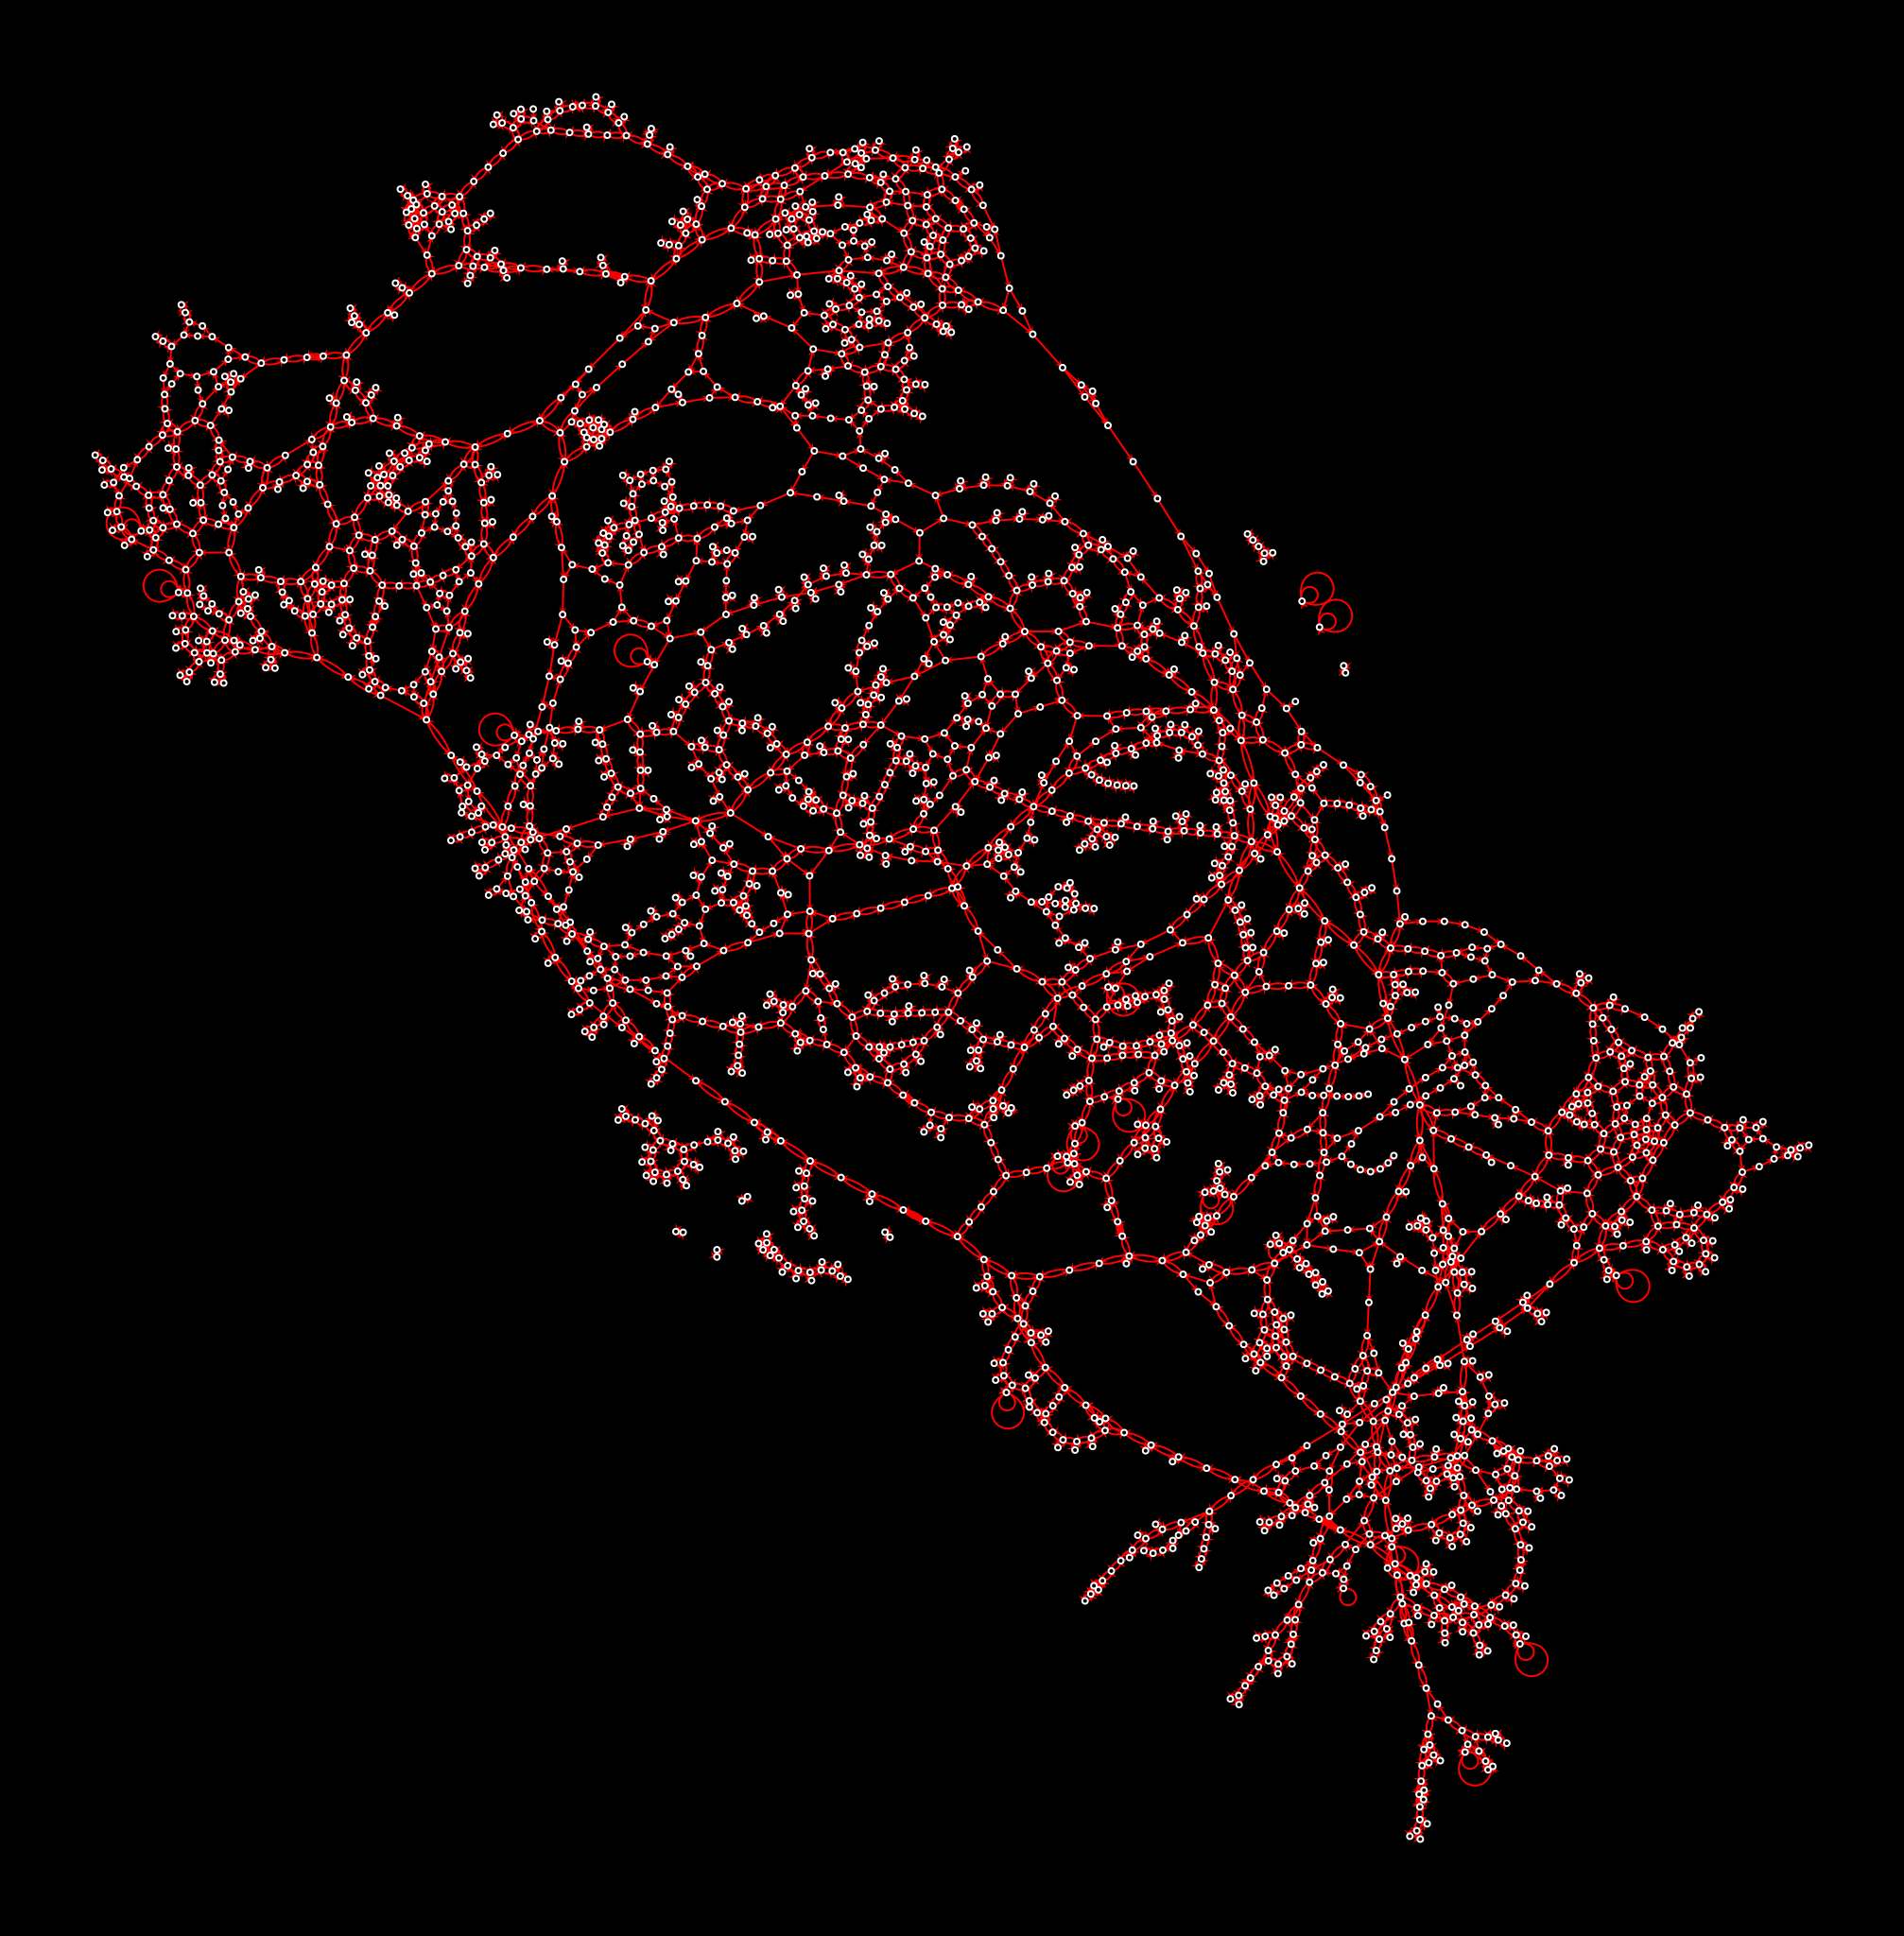

CPU times: user 24.6 s, sys: 132 ms, total: 24.7 s
Wall time: 8.91 s


In [6]:
%%time
graph = roads_initialized.get_graph()

# a plot method has been added on OsmGT.
graph.plot()

## Compute a shortest path 

### With graph-tools function

In [7]:
%%time
# now, we have to define a start point and a end point and get their wkt
start_node_topo_uuid = 47
end_node_topo_uuid = 63

# 'topo_uuid' is generated by osmgt (during the topology processing).
# Some roads has been split that's whyso this id has been created.
start_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == start_node_topo_uuid]
end_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == end_node_topo_uuid]

start_node_wkt = start_node_gdf.iloc[0]["geometry"].wkt
end_node_wkt = end_node_gdf.iloc[0]["geometry"].wkt

# the graph have some methods (graph-tools method always exists!) to find egdes, vertices... Let's use the .find_vertex_from_name(). the wkt is the vertex name...
source_vertex = graph.find_vertex_from_name(start_node_wkt)
target_vertex = graph.find_vertex_from_name(end_node_wkt)

# shortest path computing...
path_vertices, path_edges = shortest_path(
    graph,
    source=source_vertex,
    target=target_vertex,
    weights=graph.edge_weights  # weigth is based on line length
)

# get path by using edge names
roads_ids = [
    graph.edge_names[edge]
    for edge in path_edges
]

roads_gdf_copy = roads_gdf.copy(deep=True)
shortest_path_found = roads_gdf_copy[roads_gdf['topo_uuid'].isin(roads_ids)].to_crs(3857)['geometry'].to_list()
shortest_path_found_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:3857", geometry=[linemerge(shortest_path_found)])

layers_to_add = [
    {
        "input_gdf": shortest_path_found_gdf,
        "legend": "shortest_path",
        "color": "red",
        "line_width": 5
    },
    {
        "input_gdf": start_node_gdf,
        "legend": "source node",
        "color": "blue",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": end_node_gdf,
        "legend": "target node",
        "color": "green",
        "style": "circle",
        "size": 9
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "My shortest path - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

CPU times: user 269 ms, sys: 20.6 ms, total: 289 ms
Wall time: 284 ms


### With OsmGt function

In [8]:
%%time

start_node_topo_uuid = 47
end_node_topo_uuid = 63

start_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == start_node_topo_uuid]
end_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == end_node_topo_uuid]

start_node = start_node_gdf.iloc[0]["geometry"]
end_node = end_node_gdf.iloc[0]["geometry"]

shortest_paths = OsmGt.shortest_path_from_location(
    "Roanne",
    [
        (start_node, end_node),
        (start_node, end_node),  # duplicate pairs are cleaned
    ],
    mode="pedestrian"
)
layers_to_add = [
    {
        "input_gdf": shortest_paths[["geometry"]],
        "legend": "shortest_path",
        "color": "red",
        "line_width": 5
    },
    {
        "input_gdf": start_node_gdf,
        "legend": "source node",
        "color": "blue",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": end_node_gdf,
        "legend": "target node",
        "color": "green",
        "style": "circle",
        "size": 9
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "My shortest path - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

display(shortest_paths)

2021-10-27 22:38:37 - OsmGtShortestPath - INFO     : Shortest path processing...
2021-10-27 22:38:37 - OsmGtShortestPath - INFO     : From location: Roanne
2021-10-27 22:38:37 - OsmGtShortestPath - INFO     : Loading data...
2021-10-27 22:38:37 - OsmGtShortestPath - INFO     : NominatimApi: Query 200:OK in 0.17 sec.
2021-10-27 22:38:41 - OsmGtShortestPath - INFO     : OverpassApi: Query 200:OK in 3.35 sec.
2021-10-27 22:38:41 - OsmGtShortestPath - INFO     : Rebuild network data
2021-10-27 22:38:41 - OsmGtShortestPath - INFO     : Network cleaning...
2021-10-27 22:38:41 - OsmGtShortestPath - INFO     : Starting: Adding new nodes on the network
2021-10-27 22:38:41 - OsmGtShortestPath - INFO     : Find nearest line for each node
2021-10-27 22:38:41 - OsmGtShortestPath - INFO     : Split line
2021-10-27 22:38:41 - OsmGtShortestPath - INFO     : Topology lines checker: to add: 2, to split: 2
2021-10-27 22:38:41 - OsmGtShortestPath - INFO     : Starting: Find intersections
2021-10-27 22:38:

source_node                   target_node  \
0  POINT (4.090984 46.057239)  POINT (4.0789385 46.0331249)   

                                             osm_ids  \
0  24040315, 24040315, 24040315, 24040315, 240403...   

                                            osm_urls  \
0  https://www.openstreetmap.org/way/24040315, ht...   

                                            geometry id  
0  LINESTRING (4.09098 46.05724, 4.09094 46.05760...  0

CPU times: user 2.11 s, sys: 125 ms, total: 2.24 s
Wall time: 5.82 s


## Compute an isochrone

### Isochrone from times

In [9]:
%%time

topo_uuids_poi = [99, 167, 188]

source_nodes = pois_gdf[pois_gdf['topo_uuid'].isin(topo_uuids_poi)]

# 2 = 2 min ; 5 = 5 min ; 10 = 10 min
isochrones_polygon_values = {
    1: "#d9ef8b",
    5: "#fee08b",
    10: "#f46d43"
}

isochrones_lines_values = {
    1: "#668100",
    5: "#e2a803",
    10: "#962603"
}

trip_speed = 0.5  # km/h

location_points = list(source_nodes["geometry"])
# location_points.extend(location_points)

isochrones_polygons, isochrones_lines = OsmGt.isochrone_times_from_nodes(
    location_points,
    list(isochrones_polygon_values.keys()),
    trip_speed,
    mode="pedestrian"
)

isochrones_polygons["color"] = isochrones_polygons["iso_name"].map(lambda x: isochrones_polygon_values[x])
isochrones_lines["color"] = isochrones_lines["iso_name"].map(lambda x: isochrones_lines_values[x])


layers_to_add = [
    {
        "input_gdf": source_nodes,
        "legend": "Source nodes",
        "style": "circle",
        "color": "red",
        "size": 5
    },
    {
        "input_gdf": isochrones_polygons,
        "legend": "iso_name",
        "fill_color": "color",
        "line_color": "color",
        "fill_alpha": 0.5
    },
    {
        "input_gdf": isochrones_lines,
        "legend": "iso_name",
        "color": "color",
        "line_width": 2
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "Isochrones from times - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

print("\nIsochrones polygons output")
display(isochrones_polygons)

print("\nIsochrones lines output")
display(isochrones_lines.head(2))


2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : Isochrone processing...
2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : From bbox: (4.068098939709741, 46.030879852328574, 4.071654160290258, 46.040020143426126)
2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : Loading data...
2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : OverpassApi: Query 200:OK in 0.23 sec.
2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : Rebuild network data
2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : Network cleaning...
2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : Starting: Adding new nodes on the network
2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : Find nearest line for each node
2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : Split line
2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : Topology lines checker: to add: 3, to split: 3
2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : Starting: Find intersections
2021-10-27 22:38:43 - OsmGtIsochrone  - INFO     : Done: Find inters

ERROR:bokeh.core.validation.check:E-1006 (NON_MATCHING_DATA_SOURCES_ON_LEGEND_ITEM_RENDERERS): LegendItem.label is a field, but renderer data sources don't match: LegendItem(id='1949', ...)



Isochrones polygons output


iso_name time_unit  iso_distance distance_unit  \
0        10   minutes            84        meters   
1        10   minutes            84        meters   
2        10   minutes            84        meters   
3         5   minutes            42        meters   
4         5   minutes            42        meters   
5         5   minutes            42        meters   
6         1   minutes             9        meters   
7         1   minutes             9        meters   
8         1   minutes             9        meters   

                                            geometry id    color  
0  POLYGON ((4.06858 46.03107, 4.06858 46.03107, ...  0  #f46d43  
1  POLYGON ((4.06983 46.03601, 4.06983 46.03602, ...  1  #f46d43  
2  POLYGON ((4.06922 46.03900, 4.06894 46.03910, ...  2  #f46d43  
3  POLYGON ((4.06930 46.03128, 4.06918 46.03124, ...  3  #fee08b  
4  POLYGON ((4.06987 46.03949, 4.07008 46.03950, ...  4  #fee08b  
5  POLYGON ((4.07050 46.03582, 4.07040 46.03587, ...  5  #fee08b  
6  POLYGON ((4.06911 46.03152, 4.06910 46.03150, ...  6  #d9ef8b  
7  POLYGON ((4.06974 46.03932, 4.06974 46.03932, ...  7  #d9ef8b  
8  POLYGON ((4.07067 46.03585, 4.07068 46.03584, ...  8  #d9ef8b


Isochrones lines output


highway             name oneway         id  \
4  tertiary  Avenue Gambetta    NaN  120171180   
5  tertiary  Avenue Gambetta    NaN  120171180   

                                       osm_url topo_uuid topology  \
4  https://www.openstreetmap.org/way/120171180     11_04    split   
5  https://www.openstreetmap.org/way/120171180     11_05    split   

  cycleway:left cycleway:right lanes  ... noname cycleway:both bicycle layer  \
4           NaN            NaN   NaN  ...    NaN           NaN     NaN   NaN   
5           NaN            NaN   NaN  ...    NaN           NaN     NaN   NaN   

  ref:FR:FANTOIR tunnel iso_name iso_distance  \
4            NaN    NaN      1.0          9.0   
5            NaN    NaN     10.0         84.0   

                                            geometry    color  
4  LINESTRING (4.06969 46.03933, 4.06972 46.03933...  #668100  
5  LINESTRING (4.06864 46.03933, 4.06875 46.03933...  #962603  

[2 rows x 30 columns]

CPU times: user 3.31 s, sys: 978 ms, total: 4.29 s
Wall time: 5.89 s


### Isochrone from distances

In [10]:
%%time

topo_uuids_poi = [99, 167, 188]

source_nodes = pois_gdf[pois_gdf['topo_uuid'].isin(topo_uuids_poi)]

# 2 = 2 min ; 5 = 5 min ; 10 = 10 min
isochrones_polygon_values = {
    20: "#d9ef8b",
    50: "#fee08b",
    100: "#f46d43"
}

isochrones_lines_values = {
    20: "#668100",
    50: "#e2a803",
    100: "#962603"
}

trip_speed = 3  # km/h

location_points = list(source_nodes["geometry"])
# location_points.extend(location_points)

isochrones_polygons, isochrones_lines = OsmGt.isochrone_distances_from_nodes(
    location_points,
    list(isochrones_polygon_values.keys()),
    trip_speed,
    mode="pedestrian"
)

isochrones_polygons["color"] = isochrones_polygons["iso_distance"].map(lambda x: isochrones_polygon_values[x])
isochrones_lines["color"] = isochrones_lines["iso_distance"].map(lambda x: isochrones_lines_values[x])


layers_to_add = [
    {
        "input_gdf": source_nodes,
        "legend": "Source nodes",
        "style": "circle",
        "color": "red",
        "size": 5
    },
    {
        "input_gdf": isochrones_polygons,
        "legend": "iso_name",
        "fill_color": "color",
        "line_color": "color",
        "fill_alpha": 0.5
    },
    {
        "input_gdf": isochrones_lines,
        "legend": "iso_name",
        "color": "color",
        "line_width": 2
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "Isochrones from times - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

print("\nIsochrones polygons output")
display(isochrones_polygons)

print("\nIsochrones lines output")
display(isochrones_lines.head(2))


2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : Isochrone processing...
2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : From bbox: (4.067912090130645, 46.03075012801111, 4.071841009869354, 46.04014984598441)
2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : Loading data...
2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : OverpassApi: Query 200:OK in 0.2 sec.
2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : Rebuild network data
2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : Network cleaning...
2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : Starting: Adding new nodes on the network
2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : Find nearest line for each node
2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : Split line
2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : Topology lines checker: to add: 3, to split: 3
2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : Starting: Find intersections
2021-10-27 22:38:49 - OsmGtIsochrone  - INFO     : Done: Find intersect

ERROR:bokeh.core.validation.check:E-1006 (NON_MATCHING_DATA_SOURCES_ON_LEGEND_ITEM_RENDERERS): LegendItem.label is a field, but renderer data sources don't match: LegendItem(id='2190', ...)



Isochrones polygons output


iso_name time_unit  iso_distance distance_unit  \
0       2.0   minutes           100        meters   
1       2.0   minutes           100        meters   
2       2.0   minutes           100        meters   
3       2.0   minutes           100        meters   
4       1.0   minutes            50        meters   
5       1.0   minutes            50        meters   
6       1.0   minutes            50        meters   
7       0.4   minutes            20        meters   
8       0.4   minutes            20        meters   
9       0.4   minutes            20        meters   

                                            geometry id    color  
0  POLYGON ((4.06865 46.03109, 4.06858 46.03107, ...  0  #f46d43  
1  POLYGON ((4.07009 46.03153, 4.07009 46.03152, ...  1  #f46d43  
2  POLYGON ((4.07017 46.03528, 4.07016 46.03529, ...  2  #f46d43  
3  POLYGON ((4.06896 46.03877, 4.06892 46.03886, ...  3  #f46d43  
4  POLYGON ((4.06936 46.03129, 4.06930 46.03128, ...  4  #fee08b  
5  POLYGON ((4.06928 46.03923, 4.06923 46.03927, ...  5  #fee08b  
6  POLYGON ((4.07094 46.03581, 4.07075 46.03582, ...  6  #fee08b  
7  POLYGON ((4.06906 46.03147, 4.06909 46.03153, ...  7  #d9ef8b  
8  POLYGON ((4.06958 46.03933, 4.06962 46.03938, ...  8  #d9ef8b  
9  POLYGON ((4.07066 46.03591, 4.07066 46.03594, ...  9  #d9ef8b


Isochrones lines output


highway             name oneway         id  \
10  tertiary  Avenue Gambetta    NaN  120171180   
11  tertiary  Avenue Gambetta    NaN  120171180   

                                        osm_url topo_uuid topology  \
10  https://www.openstreetmap.org/way/120171180    13_010    split   
11  https://www.openstreetmap.org/way/120171180    13_011    split   

   cycleway:left cycleway:right lanes  ... bicycle layer ref:FR:FANTOIR  \
10           NaN            NaN   NaN  ...     NaN   NaN            NaN   
11           NaN            NaN   NaN  ...     NaN   NaN            NaN   

   source:name bridge tunnel iso_name iso_distance  \
10         NaN    NaN    NaN      0.4         20.0   
11         NaN    NaN    NaN      1.0         50.0   

                                             geometry    color  
10  LINESTRING (4.06954 46.03933, 4.06962 46.03933...  #668100  
11  LINESTRING (4.06914 46.03933, 4.06922 46.03933...  #e2a803  

[2 rows x 34 columns]

CPU times: user 2.65 s, sys: 10.1 ms, total: 2.66 s
Wall time: 3.35 s
